In [1]:
import os
import time

# import sklearn.linear_model
import pandas as pd
import sklearn.ensemble
import sklearn.linear_model as sklm
import sklearn.neural_network as sknn
import vaex
import vaex.ml
import vaex.ml.sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# vaex.settings.main.thread_count = 20

In [2]:
features = ['EventType', 'EventDetails', 'EventCountry', 'Actor1Code', 'Actor1Name']
target = 'AvgTone'

In [3]:
def vx_reader(folder):
    print("Starting read")
    read_time = time.time()
    df = vaex.open(folder,
                   dtype={'Actor1Code': str,
                          'Actor1Name': str,
                          'EventCode': str,
                          'ActionGeo_ADM1Code': str,
                          'SQLDATE': str})
    print("Read completed in", time.time() - read_time, "seconds")
    print("Starting cleanup")
    clean_time = time.time()
    df.dropna()
    df = df[df.NumMentions > 2000]
    df = df[df.SQLDATE > 20000000]
    df['EventType'] = df.EventCode.str.slice(start=0, stop=2)
    df['EventDetails'] = df.EventCode.str.slice(start=2)
    df['EventCountry'] = df.ActionGeo_ADM1Code.str.slice(start=0, stop=2)
    df['EventRegion'] = df.ActionGeo_ADM1Code.str.slice(start=2)
    # df['Year'] = df.SQLDATE.str.slice(start=0, stop=4)
    # df['Month'] = df.SQLDATE.str.slice(start=4, stop=6)
    # df['Month'] = df.Month.astype('str')
    df = df.drop(['EventCode', 'ActionGeo_ADM1Code'])
    df = df.dropna()
    # df = df[df.NumMentions > 500]
    print("Cleanup completed in", time.time() - clean_time, "seconds")
    test = df[df.SQLDATE > 20200000]
    train = df[df.SQLDATE < 20200000]
    # print(df.head(5))
    return test, train, df


test_df, df, raw = vx_reader("data")

Starting read
Read completed in 0.9666252136230469 seconds
Starting cleanup
Cleanup completed in 1.1245028972625732 seconds


In [4]:
def binary_encode(df, test_df, features):
    binary_encoder = vaex.ml.MultiHotEncoder(features=features)
    binary_encoded_df = binary_encoder.fit_transform(df)
    binary_encoded_test = binary_encoder.transform(test_df)
    return binary_encoded_df, binary_encoded_test


bin_df, bin_test = binary_encode(df, test_df, features)

In [6]:
bin_pd = bin_df.to_pandas_df()
test_pd = bin_test.to_pandas_df()
raw_pd = raw.to_pandas_df()
# num_plot = sns.pairplot(raw_pd, corner=True)
# num_plot.savefig('num_plots.png')
# # num_img.savefig()
# g = sns.PairGrid(raw_pd, y_vars=['NumMentions', 'AvgTone'], x_vars=['Actor1Code', 'EventType', 'EventCountry'])
# g.savefig('cat_plots.png')
# g.map(sns.pointplot, scale=1.3, errwidth=4)
# plt.show

In [ ]:
# full_num_plot = sns.pairplot(bin_pd, corner=True)
# full_num_plot.savefig('train_num_plots.png')

In [ ]:
# print(test_pd.head())

In [7]:
def lin_reg(df, test_df):
    X = df.drop(['GLOBALEVENTID', 'SQLDATE', 'Actor1Code', 'Actor1Name', 'EventCountry', 'EventRegion', 'AvgTone'], axis=1)
    # print(X.head())
    X_test = test_df.drop(['GLOBALEVENTID', 'SQLDATE', 'Actor1Code', 'Actor1Name', 'EventCountry', 'EventRegion', 'AvgTone'], axis=1)
    # print(X_test.head())
    y = pd.DataFrame(df['AvgTone'])
    # print(y.head())
    y_test = pd.DataFrame(test_df['AvgTone'])
    # print(y_test.head())
    model = sklm.LinearRegression()
    model.fit(X, y)
    init_preds = model.predict(X)
    preds = model.predict(X_test)
    init_score = model.score(X, y)
    score = model.score(X_test,y_test)
    print(init_score)
    print(score)
    # print(preds)
    return preds, init_preds, score, init_score, X, X_test, y, y_test

lm_preds, lm_init_preds, lm_score, lm_init_score, lm_X, lm_X_test, lm_y, lm_y_test = lin_reg(bin_pd, test_pd)


0.25881717213078004
0.23761713626570946


In [ ]:
# plt.scatter(lm_X['NumMentions'], lm_y)
# plt.plot(lm_X["NumMentions"], lm_init_preds)
# plt.title("Training")
# # plt.xlabal("Training data")
# plt.xlabel('NumMentions')
# plt.show()
# plt.savefig("NumMentions.png")

In [ ]:

# for X_col in X.columns:
#     plt.scatter(X[X_col], y)
#     plt.plot(X[X_col], svm_init_preds)
#     plt.title("Training")
#     # plt.xlabal("Training data")
#     plt.xlabel(X_col)
#     plt.show()
#     plt.savefig(X_col + ".png")

In [15]:
def random_forest(df, test_df):
    X = df.drop(['GLOBALEVENTID', 'SQLDATE', 'Actor1Code', 'Actor1Name', 'EventCountry', 'EventRegion', 'AvgTone'], axis=1)
    # print(X.head())
    X_test = test_df.drop(['GLOBALEVENTID', 'SQLDATE', 'Actor1Code', 'Actor1Name', 'EventCountry', 'EventRegion', 'AvgTone'], axis=1)
    # print(X_test.head())
    y = np.ravel(pd.DataFrame(df['AvgTone']))
    # print(y.head())
    y_test = np.ravel(pd.DataFrame(test_df['AvgTone']))
    # print(y_test.head())
    model = sklearn.ensemble.RandomForestRegressor(n_jobs=-1)
    model.fit(X, y)
    init_path = model.decision_path(X)
    path = model.decision_path(X_test)
    init_preds = model.predict(X)
    preds = model.predict(X_test)
    init_score = model.score(X, y)
    score = model.score(X_test,y_test)
    print(init_score)
    print(score)
    # print(preds)
    return preds, init_preds, score, init_score, path, init_path, X, X_test, y, y_test, model

rf_preds, rf_init_preds, rf_score, rf_init_score, rf_path, rf_init_path, rf_X, rf_X_test, rf_y, rf_y_test, model = random_forest(bin_pd, test_pd)

0.9100409222412917
0.20565580252682536


(<8364x8203380 sparse matrix of type '<class 'numpy.int64'>'
	with 19706103 stored elements in Compressed Sparse Row format>, array([      0,   81917,  164080,  246013,  327940,  410155,  492260,
        574319,  656110,  738351,  820230,  902715,  984808, 1066849,
       1149064, 1230949, 1312932, 1395159, 1477176, 1559265, 1641232,
       1723021, 1804976, 1887063, 1969172, 2051133, 2133250, 2215227,
       2297164, 2379597, 2461404, 2543471, 2625458, 2707421, 2789524,
       2871487, 2953830, 3035993, 3117958, 3199953, 3281966, 3364033,
       3445926, 3528287, 3610342, 3692733, 3774968, 3857047, 3938894,
       4020739, 4102832, 4184871, 4266878, 4348849, 4430792, 4512827,
       4594894, 4676999, 4758982, 4840799, 4922870, 5005111, 5087026,
       5169023, 5251012, 5332849, 5414934, 5496817, 5578680, 5660579,
       5742946, 5824967, 5907036, 5988911, 6070882, 6153149, 6235248,
       6317173, 6399170, 6480853, 6562782, 6644881, 6726892, 6809079,
       6891196, 6973275, 7055248, 

AttributeError: 'RandomForestRegressor' object has no attribute 'tree_'

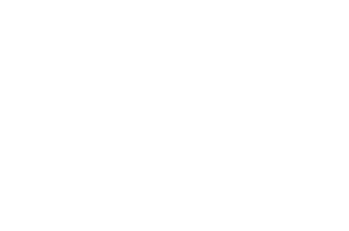

In [16]:
print(rf_path)
sklearn.tree.plot_tree(model, feature_names=rf_X.columns)

In [9]:
def svm(df, test_df):
    X = df.drop(['GLOBALEVENTID', 'SQLDATE', 'Actor1Code', 'Actor1Name', 'EventCountry', 'EventRegion', 'AvgTone'], axis=1)
    # print(X.head())
    X_test = test_df.drop(['GLOBALEVENTID', 'SQLDATE', 'Actor1Code', 'Actor1Name', 'EventCountry', 'EventRegion', 'AvgTone'], axis=1)
    # print(X_test.head())
    y = np.ravel(pd.DataFrame(df['AvgTone']))
    # print(y.head())
    y_test = np.ravel(pd.DataFrame(test_df['AvgTone']))
    # print(y_test.head())
    model = sklearn.svm.SVR()
    model.fit(X, y)
    init_preds = model.predict(X)
    preds = model.predict(X_test)
    init_score = model.score(X, y)
    score = model.score(X_test,y_test)
    print(init_score)
    print(score)
    # print(preds)
    return preds, init_preds, score, init_score, X, X_test, y, y_test

svm_preds, svm_init_preds, svm_score, svm_init_score, svm_X, svm_X_test, svm_y, svm_y_test = svm(bin_pd, test_pd)

0.03180567915944965
0.026456959717162887


In [10]:
def nn(df, test_df):
    X = df.drop(['GLOBALEVENTID', 'SQLDATE', 'Actor1Code', 'Actor1Name', 'EventCountry', 'EventRegion', 'AvgTone'], axis=1)
    # print(X.head())
    X_test = test_df.drop(['GLOBALEVENTID', 'SQLDATE', 'Actor1Code', 'Actor1Name', 'EventCountry', 'EventRegion', 'AvgTone'], axis=1)
    # print(X_test.head())
    y = np.ravel(pd.DataFrame(df['AvgTone']))
    # print(y.head())
    y_test = np.ravel(pd.DataFrame(test_df['AvgTone']))
    # print(y_test.head())
    model = sknn.MLPRegressor(early_stopping=True, max_iter=1000, learning_rate='adaptive')
    model.fit(X.values, y)
    init_preds = model.predict(X.values)
    preds = model.predict(X_test.values)
    init_score = model.score(X.values, y)
    score = model.score(X_test.values,y_test)
    print(init_score)
    print(score)
    # print(preds)
    return preds, init_preds, score, init_score, X, X_test, y, y_test

nn_preds, nn_init_preds, nn_score, nn_init_score, nn_X, nn_X_test, nn_y, nn_y_test = nn(bin_pd, test_pd)
#     preds = model.predict(X.values)
#     score = model.score(X_test.values, y_test)
#     # print(model.n_iter)
#     print(score)
#     return preds, score
#
# nn_preds, nn_score = nn(bin_pd, test_pd)

0.24273410823070907
0.20849826552559836


In [11]:
print(bin_pd.shape)
print(test_pd.shape)
print("R2's (Train/Test):")
print("LinReg:", lm_init_score, "/", lm_score)
print("Random Forest:", rf_init_score, "/", rf_score)
print("SVR:", svm_init_score, "/", svm_score)
print("NN:", nn_init_score, "/", nn_score)

(68048, 52)
(8364, 52)
R2's (Train/Test):
LinReg: 0.25881717213078004 / 0.23761713626570946
Random Forest: 0.9098906539922159 / 0.21151952228782245
SVR: 0.03180567915944965 / 0.026456959717162887
NN: 0.24273410823070907 / 0.20849826552559836
